In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import talib
import warnings
warnings.filterwarnings("ignore")

In [3]:
#read data
df = pd.read_csv('Data/July_01-12_2022_BTCUSDT_data.csv')
# df = pd.read_csv('BTC-USDT_Hourly chart - Binance_BTCUSDT_1h (1).csv')
# df = pd.read_csv('BTC_hourly_2018-2022 - Sheet1.csv')
df2 = df.copy()


In [4]:
len(df2)

987485

In [9]:
df2['close'] = df2['Close']

In [10]:
df2.tail()

,Unnamed: 0,Quotient,TimeStamp,Close,Open,High,Low,Volume,close
987480,987480,1657670395,2022-07-13 05:29:55,19332.42,19331.23,19332.94,19329.10,0.23427,19332.42
987481,987481,1657670396,2022-07-13 05:29:56,19333.52,19332.42,19333.52,19330.89,0.39074,19333.52
987482,987482,1657670397,2022-07-13 05:29:57,19333.51,19332.42,19333.52,19331.53,0.18587,19333.51
987483,987483,1657670398,2022-07-13 05:29:58,19332.35,19333.28,19333.28,19332.35,0.16618,19332.35
987484,987484,1657670399,2022-07-13 05:29:59,19328.75,19333.13,19333.99,19328.75,0.50966,19328.75


Strategy Returns from above strategy:  99446   NaN
Name: strategy_return1, dtype: float64 %
Market returns:  99446    0.974724
Name: cc_returns, dtype: float64


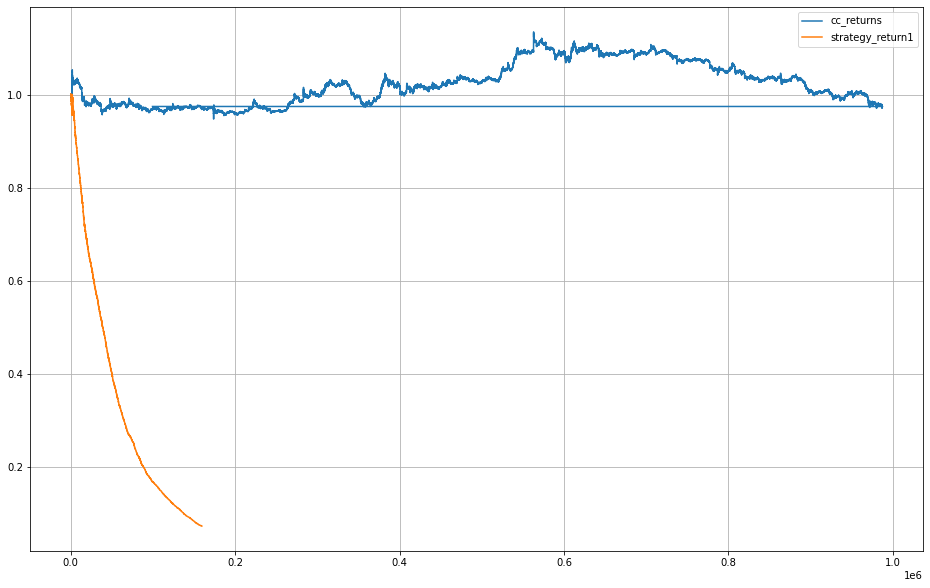

In [16]:
# df = pd.read_csv('BTC-USDT_Hourly chart - Binance_BTCUSDT_1h (1).csv')
# df2 = df.copy()
#schaff trend cycle
def stc(df):
#     df['close'] = df['Close']

    df['ema_23c'] = df['close'].ewm(span=23, adjust=False).mean()
    df['ema_50c'] = df['close'].ewm(span=50, adjust=False).mean()
    
    df['macdc'] = df['ema_23c'] - df['ema_50c']
    
    df['lowl'] = df['macdc'].rolling(10).min()
    
    df['highh'] = df['macdc'].rolling(10).max()
    
    
    df['%k'] =100* ((df['macdc'] - df['lowl'])/(df['highh'] - df['lowl']))
    df['%d'] = df['%k'].rolling(window=3).mean()
#     df['%k'] = df['%k1'].rolling(window = 3).mean()



stc(df2)
df2.reset_index
df2 = df2.dropna(subset=['%d'])


df2['ema100'] = df2['close'].ewm(span=300, adjust=False).mean()
# df2['+DI']= talib.PLUS_DI(df2['high'], df2['low'],df2['close'], timeperiod=7)
# df2['-DI']= talib.MINUS_DI(df2['high'], df2['low'],df2['close'], timeperiod=7)
df2['Schaff'] = 100 * ((df2['macdc'] - df2['%d']) / (df2['%k'] - df2['%d']))

index0 = df2.index[0]
#parameter
lowcut = 10
highcut = 90
slippage = 0.0005
# df2['slip'] = 0
#making position
for i in range(index0, len(df2['close']) + index0 ):
    try:
        if i ==index0: 
            df2.loc[i,'position'] = 0

        elif (df2.loc[i-1,'position'] == 0):
            if(( df2.loc[i, '%d'] > lowcut ) & (df2.loc[i-1,'%d'] < lowcut ) & (df2.loc[i, 'close'] > df2.loc[i,'ema100'])):
                df2.loc[i,'position'] = 1
                df2.loc[i,'slip'] = slippage 


            elif((df2.loc[i,'%d'] < highcut ) & (df2.loc[i-1,'%d']> highcut ) & (df2.loc[i,'close'] < df2.loc[i, 'ema100'])):
                df2.loc[i,'position'] = -1                
                df2.loc[i,'slip'] = slippage 


            else:
                df2.loc[i,'position'] = 0
                df2.loc[i,'slip'] = slippage*0

        elif df2.loc[i-1,'position'] ==1:
            if ((df2.loc[i,'%d'] < highcut ) &  (df2.loc[i-1,'%d'] > highcut ) & (df2.loc[i,'close'] > df2.loc[i, 'ema100'])):
                df2.loc[i,'position'] = 0
                df2.loc[i,'slip'] = slippage

            elif((df2.loc[i,'%d'] < highcut ) & (df2.loc[i-1,'%d']> highcut ) & (df2.loc[i,'close'] < df2.loc[i, 'ema100'])):
                df2.loc[i,'position'] = -1
                df2.loc[i,'slip'] = 2*slippage

            else:
                df2.loc[i,'position'] = 1
                df2.loc[i,'slip'] = slippage* 0

        elif df2.loc[i-1,'position'] == -1:
            if ((df2.loc[i,'%d'] >lowcut ) &  (df2.loc[i-1,'%d'] < lowcut )& (df2.loc[i,'close'] < df2.loc[i, 'ema100'])):
                df2.loc[i,'position'] = 0
                df2.loc[i,'slip'] = slippage

            elif(( df2.loc[i, '%d'] > lowcut ) & (df2.loc[i-1,'%d'] < lowcut ) & (df2.loc[i, 'close'] > df2.loc[i,'ema100'])):
                df2.loc[i,'position'] = 1
                df2.loc[i,'slip'] = slippage*2

            else:
                df2.loc[i,'position'] = -1
                df2.loc[i,'slip'] = slippage*0
    except:
        pass
#     df2['position'] = np.where(((df2['%k'] > 10 ) & (df2['%k'].shift(1) < 10 ) & (df2['close'] > df2['ema100'])), 1, np.nan)
#     df2['position'] = np.where(((df2['%k'] < 90 ) &  (df2['%k'].shift(1) > 90 )) , 0, df2['position'])


#     except:
#         pass
#shift in position
df2['position'] = df2['position'].shift(1)

#Returns calculation
df2['return'] = df2['close'].pct_change()
df2['strategy_return'] = df2['position']*df2['return'] - df2['slip']
df2['strategy_return1'] = 1 + df2['strategy_return']
df2['cc_return'] = 1+df2['return']

#plot
df2[['cc_returns', 'strategy_return1']] = df2[['cc_return', 'strategy_return1']].cumprod()
df2[['cc_returns', 'strategy_return1'  ]].plot(secondary_y='position', grid=True, figsize=(16, 10))

print('Strategy Returns from above strategy: ',df2['strategy_return1'][-1:,]* 100 , '%')
print('Market returns: ',df2['cc_returns'][-1:,])


In [80]:
# df2.to_csv('stc_final.csv')

Maximum Drawdown of strategy is:  -30.1 %


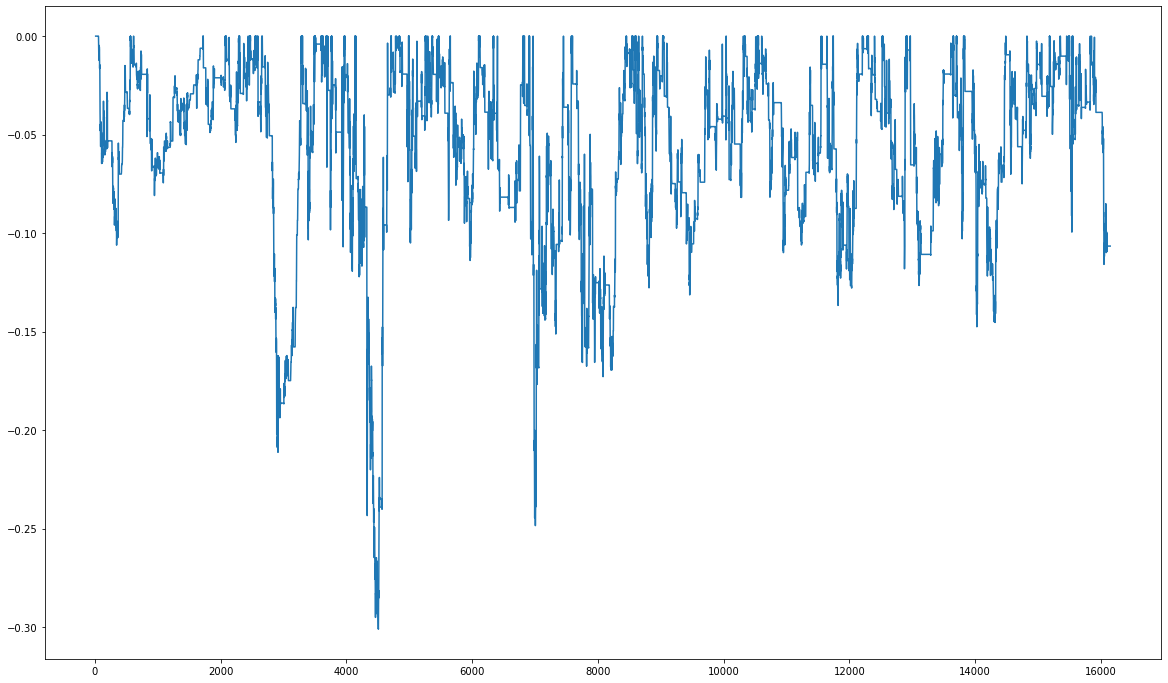

In [79]:
import pandas_datareader as  web
import datetime
# SPY_Dat = web.DataReader('SPY', 'yahoo', datetime.date(2007,1,1))

window = 365


Roll_Max = df2['strategy_return1'].rolling(window, min_periods=1).max()
Daily_Drawdown = df2['strategy_return1']/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

Daily_Drawdown.plot(figsize = (20,12))
# Max_Daily_Drawdown.plot()
a = Daily_Drawdown.dropna()
print('Maximum Drawdown of strategy is: ',round(min(a)*100, 2) , '%')

plt.show()

In [75]:
#calculation of sharpe ratio
stdd = np.array(df2['strategy_return'].dropna())
std = stdd.std()
mean = stdd.mean() 
print('Sharpe Ratio: ',(mean/std)*np.sqrt(365*24))

#mean returns
print('Annaulized return: ',mean*365*24*100)

print('Annaulized Volatility: ',std*np.sqrt(365*24)*100)


Sharpe Ratio:  1.5904531237642954
Annaulized return:  87.86024976633709
Annaulized Volatility:  55.24227558394733


In [71]:
# import plotly.graph_objects as go

# import pandas as pd
# from datetime import datetime
# from plotly.subplots import make_subplots

# fig = go.Figure()
# # add OHLC trace
# fig = make_subplots(rows=4, cols=1, shared_xaxes=True)


# fig.add_trace(go.Candlestick(x=df2['date'],
#                              open=df2['open'],
#                              high=df2['high'],
#                              low=df2['low'],
#                              close=df2['close'], 
#                              showlegend=False))


# fig.update_layout(xaxis_rangeslider_visible=False)

# fig.add_trace(go.Scatter(x=df2['date'],
#                          y=df2['%k'],
#                          line=dict(color='blue')
#                         ), row=2, col=1)

# fig.add_trace(go.Scatter(x=df2['date'],
#                          y=df2['%d'],
#                          line=dict(color='red', width=1)
#                         ), row=2, col=1)

# fig.add_trace(go.Scatter(x=df2['date'], 
#                          y=df2['ema100'], 
#                          opacity=0.7, 
#                          line=dict(color='blue', width=2), 
#                          name='MA 100'))




# fig.add_trace(go.Scatter(x=df2['date'],
#                          y=df2['position'],
#                          line=dict(color='green')
#                         ), row=3, col=1)


# fig.add_trace(go.Scatter(x=df2['date'],
#                          y=df2['strategy_return1'],
#                          line=dict(color='orange')
#                         ), row=4, col=1)

# fig.add_trace(go.Scatter(x=df2['date'],
#                          y=df2['cc_returns'],
#                          line=dict(color='blue')
#                         ), row=4, col=1)

# fig.update_layout(height= 1000, width = 1200)